# MNIST I

Alice, Bob, and Daniel are friends learning machine learning together. After watching a few lectures, they are very proud of having learned many useful tools, including linear and logistic regression, non-linear features, regularization, and kernel tricks. To see how these methods can be used to solve a real life problem, they decide to get their hands dirty with the famous digit recognition problem using the MNIST (Mixed National Institute of Standards and Technology) database.

The MNIST database contains binary images of handwritten digits commonly used to train image processing systems. The digits were collected from among Census Bureau employees and high school students. The database contains 60,000 training digits and 10,000 testing digits, all of which have been size-normalized and centered in a fixed-size image of 28 × 28 pixels

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")
from utils import *
from svm import *
from kernel import *

In [2]:
def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

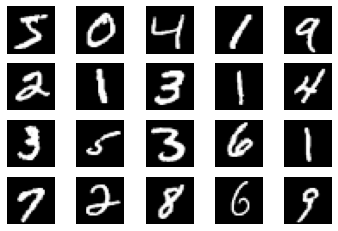

In [3]:
train_x, train_y, test_x, test_y = get_MNIST_data()
# Plot the first 20 images of the training set.
plot_images(train_x[0:20, :])

To solve the linear regression problem, you recall the linear regression has a closed form solution:
    $$\displaystyle  \displaystyle \theta = (X^ T X + \lambda I)^{-1} X^ T Y.$$

In [ ]:
def closed_form(X, Y, lambda_factor):
    """
    Computes the closed form solution of linear regression with L2 regularization
    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    theta = np.linalg.inv(X.T.dot(X) + lambda_factor*np.eye(X.shape[1])).dot(X.T).dot(Y)
    
    return theta


In [ ]:
def compute_test_error_linear(test_x, Y, theta):
    test_y_predict = np.round(np.dot(test_x, theta))
    test_y_predict[test_y_predict < 0] = 0
    test_y_predict[test_y_predict > 9] = 9
    return 1 - np.mean(test_y_predict == Y)

In [ ]:
def run_linear_regression_on_MNIST(lambda_factor=1):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    return test_error

In [ ]:
run_linear_regression_on_MNIST()

Alice and you find that no matter what $\lambda$ factor you try, the test error is large. With some thinking, you realize that something is wrong with this approach: The closed form solution of linear regression is the solution of optimizing the mean squared error loss. This is not an appropriate loss function for a classification problem.

Bob thinks it is clearly not a regression problem, but a classification problem. He thinks that we can change it into a binary classification and use the support vector machine we learned in Lecture 4 to solve the problem. In order to do so, he suggests that we can build an one vs. rest model for every digit. For example, classifying the digits into two classes: 0 and not 0.

Bob wrote a function run_svm_one_vs_rest_on_MNIST where he changed the labels of digits 1-9 to 1 and keeps the label 0 for digit 0. He also found that sklearn package contains an SVM model that you can use directly. He gave you the link to this model and hopes you can tell him how to use that.

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation
    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    svc = LinearSVC(C = 0.1, random_state = 0)
    svc.fit(train_x, train_y)
    
    pred_test_y = svc.predict(test_x)
    
    return pred_test_y

In [ ]:
def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('SVM one vs. rest test_error:', run_svm_one_vs_rest_on_MNIST())

C represents the tolerance of error. A larger C means we are punishing more on the classification error, thus being less tolerant to misclassifications. Therefore, we will get a smaller margin hyperplane.

- Larger C gives smaller tolerance of violation.

- Larger C gives a smaller-margin separating hyperplane.

In [ ]:
def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy
    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = LinearSVC(C = 0.1, random_state = 0)
    clf.fit(train_x, train_y)
    
    pred_test_y = clf.predict(test_x)
    
    return pred_test_y 

In [ ]:
def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('Multiclass SVM test_error:', run_multiclass_svm_on_MNIST())

# Multinomial (Softmax) Regression and Gradient Descent

Daniel suggests that instead of building ten models, we can expand a single logistic regression model into a multinomial regression and solve it with similar gradient descent algorithm.


For each data points $x^{(i)}$, we want compute the probability that $x^{(i)}$ is labeled as $j$ for $j=0,1,\dots, k-1$

![Title](comprob.png)

In [ ]:
from scipy.sparse import coo_matrix

Computes, for each datapoint $X[i]$, the probability that $X[i]$ is labeled as $j$ for $j = 0, 1, \dots , k-1$

In [ ]:
def compute_probabilities(X, theta, temp_parameter):
    """
    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    a = (theta @ X.T) / temp_parameter
    c = np.max(a, axis=0)
    z = a - c
    exp_z = np.exp(z)
    return exp_z/exp_z.sum(axis=0)


![cost](cost.png)

In [ ]:
def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    #YOUR CODE HERE
    N = X.shape[0]
    prob = compute_probabilities(X,theta,temp_parameter)
    # for each data point select the probability of corresponding label
    # e.g label for image1 = 1 = y1 then out of all P(y1 = 0 | x1, theta) to P(y1 = 9 | x1, theta) select P(y1 = 1 | x1, theta)
    # these probabilities are given by compute_probabilities or SoftMax Function
    selected_prob = np.choose(Y, prob)  # Shape = [n,]
    non_regulized_cost = (- 1/N) * (np.sum(np.log(selected_prob)))
    regulized_cost = (lambda_factor/2.0) * (np.sum(np.square(theta)))
    return non_regulized_cost + regulized_cost
   

![grad1](grad1.png)

![grad2](grad2.png)

In [ ]:
def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent
    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    #YOUR CODE HERE
    n = X.shape[0]
    probabilities = compute_probabilities(X, theta, temp_parameter)

    columns = np.arange(probabilities.shape[1])
    data = np.ones(probabilities.shape[1])
    one_and_zeros = coo_matrix((data, (Y, columns)), shape = (probabilities.shape[0], probabilities.shape[1])).toarray()
    
    difference = one_and_zeros - probabilities

    gradient = -(1/(n * temp_parameter)) * np.matmul(difference, X) + lambda_factor * theta

    theta -= alpha * gradient

    return theta

Smaller temperature parameter means that there is less variance in our distribution, and larger temperature, more variance. In other words smaller temperature parameter favors larger thetas, and larger temperature parameter makes the distribution more uniform.

In [ ]:
def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].
    Args:
        X - a NumPy matrix of n data points, each with d - 1 features
    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

In [ ]:
def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

- Error($T=0.5$)=0.0839
- Error($T=1$)=0.1005
- Error($T=2$)=0.1261

Given that we already classified every  as a digit, we could use the model we already trained and just calculate our estimations (mod 3).

In [ ]:
def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    #YOUR CODE HERE
    return train_y % 3, test_y % 3

In [ ]:
def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset
    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

In [ ]:
def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    #YOUR CODE HERE
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(np.remainder(assigned_labels, 3) == Y)

In [ ]:
def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()

Now suppose that instead we want to retrain our classifier with the new labels. In other words, rather than training the model to predict the original digits and then taking those predictions modulo 3, we explicitly train the model to predict the digits modulo 3 from the original image.

How do you expect the performance to change using the new labels?
 We are trying to find common features of all numbers that have the same mod 3 value, however a lot of them look widely different, so it is harder to separate the data set into 3 groups since, for example, 2 does not share many features with 5 or 8. Therefore one would expect the performance to decrease, and this is what happens.
 
 Error rate when trained on labels mod 3: 0.1872

In [ ]:
def run_softmax_on_MNIST_mod3_x(temp_parameter=1):
    """
    Trains Softmax regression on digit (mod 3) classifications.
    See run_softmax_on_MNIST for more info.
    """
    # YOUR CODE HERE
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y_mod3, test_y_mod3 = update_y(train_y, test_y)
    theta, cost_function_history = softmax_regression(train_x, train_y_mod3, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error_mod3(test_x, test_y_mod3, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # TODO: add your code here for the "Using the Current Model" question in tab 4.
    #      and print the test_error_mod3
    return test_error

print('Error of Softmax regression on digit (mod 3) classifications.', run_softmax_on_MNIST_mod3_x(temp_parameter=1))

## Classification Using Manually Crafted Features

In [4]:
def center_data(X):
    feature_means = X.mean(axis=0)
    return (X - feature_means)

In [5]:
def project_onto_PC(X, pcs, n_components, feature_means):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.
    """
    centered_data = X - feature_means
    return np.dot(centered_data, pcs[:, range(n_components)])

In [6]:
def principal_components(centered_data):
    scatter_matrix = np.dot(centered_data.transpose(), centered_data)
    eigen_values, eigen_vectors = np.linalg.eig(scatter_matrix)
    # Re-order eigenvectors by eigenvalue magnitude:
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    return eigen_vectors

In [ ]:
def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)

In [ ]:
n_components = 18

###Correction note:  the following 4 lines have been modified since release.

train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)
theta, cost_function_history = softmax_regression(train_pca, train_y, temp_parameter=1, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)

In [ ]:
compute_test_error(test_pca, test_y, theta, temp_parameter=1)

In [ ]:
def plot_PC(X, pcs, labels, feature_means):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function projects each sample in X onto the first two principal components
    and produces a scatterplot where points are marked with the digit depicted in
    the corresponding image.
    labels = a numpy array containing the digits corresponding to each image in X.
    """
    pc_data = project_onto_PC(X, pcs, n_components=2, feature_means=feature_means)
    text_labels = [str(z) for z in labels.tolist()]
    fig, ax = plt.subplots()
    ax.scatter(pc_data[:, 0], pc_data[:, 1], alpha=0, marker=".")
    for i, txt in enumerate(text_labels):
        ax.annotate(txt, (pc_data[i, 0], pc_data[i, 1]))
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.show()

In [ ]:
## Dimensionality reduction via PCA ##

# TODO: First fill out the PCA functions in features.py as the below code depends on them.


n_components = 18

###Correction note:  the following 4 lines have been modified since release.
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)

# train_pca (and test_pca) is a representation of our training (and test) data
# after projecting each example onto the first 18 principal components.


# TODO: Train your softmax regression model using (train_pca, train_y)
#       and evaluate its accuracy on (test_pca, test_y).


# TODO: Use the plot_PC function in features.py to produce scatterplot
#       of the first 100 MNIST images, as represented in the space spanned by the
#       first 2 principal components found above.
plot_PC(train_x[range(0, 100), ], pcs, train_y[range(0, 100)], feature_means)#feature_means added since release


## Cubic

In [ ]:
def cubic_features(X):
    """
    Returns a new dataset with features given by the mapping
    which corresponds to the cubic kernel.
    """
    n, d = X.shape  # dataset size, input dimension
    X_withones = np.ones((n, d + 1))
    X_withones[:, :-1] = X
    new_d = 0  # dimension of output
    new_d = int((d + 1) * (d + 2) * (d + 3) / 6)

    new_data = np.zeros((n, new_d))
    col_index = 0
    for x_i in range(n):
        X_i = X[x_i]
        X_i = X_i.reshape(1, X_i.size)

        if d > 2:
            comb_2 = np.matmul(np.transpose(X_i), X_i)

            unique_2 = comb_2[np.triu_indices(d, 1)]
            unique_2 = unique_2.reshape(unique_2.size, 1)
            comb_3 = np.matmul(unique_2, X_i)
            keep_m = np.zeros(comb_3.shape)
            index = 0
            for i in range(d - 1):
                keep_m[index + np.arange(d - 1 - i), i] = 0

                tri_keep = np.triu_indices(d - 1 - i, 1)

                correct_0 = tri_keep[0] + index
                correct_1 = tri_keep[1] + i + 1

                keep_m[correct_0, correct_1] = 1
                index += d - 1 - i

            unique_3 = np.sqrt(6) * comb_3[np.nonzero(keep_m)]

            new_data[x_i, np.arange(unique_3.size)] = unique_3
            col_index = unique_3.size

    for i in range(n):
        newdata_colindex = col_index
        for j in range(d + 1):
            new_data[i, newdata_colindex] = X_withones[i, j]**3
            newdata_colindex += 1
            for k in range(j + 1, d + 1):
                new_data[i, newdata_colindex] = X_withones[i, j]**2 * X_withones[i, k] * (3**(0.5))
                newdata_colindex += 1

                new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k]**2 * (3**(0.5))
                newdata_colindex += 1

                if k < d:
                    new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k] * (6**(0.5))
                    newdata_colindex += 1

    return new_data


In [ ]:
n_components = 18
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)

train_pca10 = train_pca[:,:10]
test_pca10 = test_pca[:,:10]
# TODO: First fill out cubicFeatures() function in features.py as the below code requires it.

train_cube = cubic_features(train_pca10)
test_cube = cubic_features(test_pca10)
# train_cube (and test_cube) is a representation of our training (and test) data
# after applying the cubic kernel feature mapping to the 10-dimensional PCA representations.


# TODO: Train your softmax regression model using (train_cube, train_y)
#       and evaluate its accuracy on (test_cube, test_y).
theta, cost_function_history = softmax_regression(train_cube, train_y, temp_parameter=1, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
test_error = compute_test_error(test_cube, test_y, theta, temp_parameter=1)
print('softmax classification error using pca10 with cubic feature representation',test_error)

In [9]:
from sklearn.svm import SVC
clfpoly = SVC(kernel='poly', random_state = 0, degree=3)

n_components = 18

feature_means = train_x.mean(axis=0)

train_x_centered = center_data(train_x)
pcs = principal_components(train_x_centered)

train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)


train_pca10 = train_pca[:,:10]
test_pca10 = test_pca[:,:10]

clfpoly.fit(train_pca10, train_y)
zpoly = clfpoly.predict(test_pca10)
test_error = 1 - np.mean(zpoly == test_y)

In [10]:
test_error

0.07350000000000001

In [11]:
from sklearn.svm import SVC
clfpoly = SVC(kernel='rbf', random_state = 0)

n_components = 18

feature_means = train_x.mean(axis=0)

train_x_centered = center_data(train_x)
pcs = principal_components(train_x_centered)

train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)


train_pca10 = train_pca[:,:10]
test_pca10 = test_pca[:,:10]


clfpoly.fit(train_pca10, train_y)
zpoly = clfpoly.predict(test_pca10)
test_error = 1 - np.mean(zpoly == test_y)
print(test_error)

0.06359999999999999
